In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
# Load the dataset
df = pd.read_csv('Car Data.csv')
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [5]:
# Rename columns for better understanding
df.rename(columns={
    'Car_Name': 'name',
    'Year': 'year',
    'Selling_Price': 'price',
    'Present_Price': 'current_price',
    'Driven_kms': 'kms',
    'Fuel_Type': 'fuel',
    'Selling_type': 'seller',
    'Transmission': 'transmission',
    'Owner': 'owner'
}, inplace=True)

In [6]:
# Handle missing values
df = df.dropna()

In [7]:
# Define numerical and categorical features
numerical_features = ['year', 'current_price', 'kms', 'owner']
categorical_features = ['name', 'fuel', 'seller', 'transmission']

In [8]:
# Split the data into features and target
X = df.drop('price', axis=1)
y = df['price']

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Define preprocessing for numerical features
numerical_transformer = SimpleImputer(strategy='mean')

In [11]:
# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [12]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [13]:
# Create preprocessing and modeling pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('scaler', StandardScaler(with_mean=False)),
                           ('regressor', LinearRegression())])

In [14]:
# Preprocess the data
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['year', 'current_price',
                                                   'kms', 'owner']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['name', 'fuel', 'seller',
                                                   'transmission'])])),
                ('scaler', StandardScaler(with_mean=False)),
                ('regressor', LinearRegression())])

In [15]:
# Make predictions
y_pred = pipeline.predict(X_test)

In [16]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [17]:
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Absolute Error: 1.0921612107715615
Mean Squared Error: 2.2598925134937216
Root Mean Squared Error: 1.5032938879320044
R-squared: 0.9018955863046081


In [20]:
# Perform k-fold cross-validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", np.mean(cv_scores))

Cross-Validation Scores: [0.55011457 0.79225316 0.7565837  0.80859222 0.81073677]
Mean Cross-Validation Score: 0.7436560854465041


In [21]:
# Define hyperparameters to tune
param_grid = {
    'regressor__alpha': [0.1, 1.0, 10.0],  # Example for Ridge Regression
    'regressor__l1_ratio': [0.1, 0.5, 0.9]  # Example for ElasticNet Regression
}

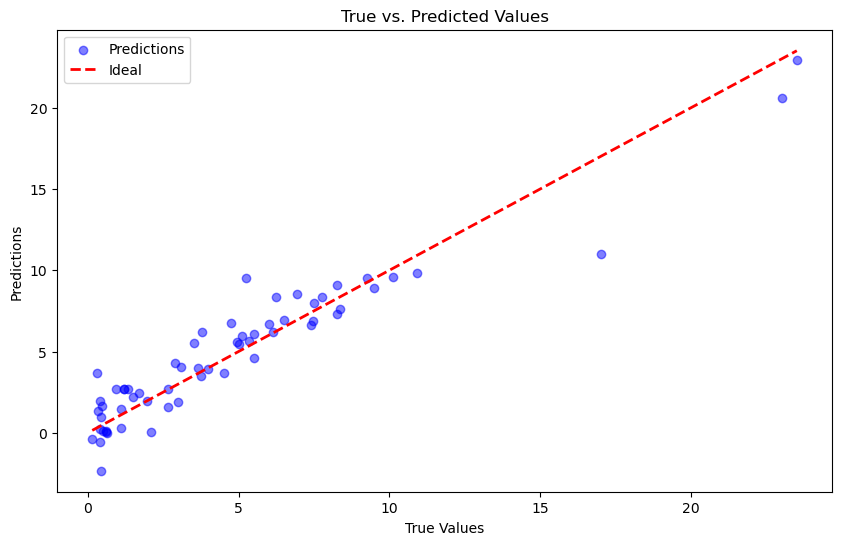

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2, label='Ideal')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.legend()
plt.show()

In [27]:
from sklearn.ensemble import RandomForestRegressor

# Create preprocessing and modeling pipeline for RandomForestRegressor
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', RandomForestRegressor(random_state=42))])

# Fit the pipeline
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['year', 'current_price',
                                                   'kms', 'owner']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['name', 'fuel', 'seller',
                                                   'transmission'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [29]:
# Feature importance (if using a tree-based model like RandomForestRegressor)
if isinstance(pipeline.named_steps['regressor'], DecisionTreeRegressor) or isinstance(pipeline.named_steps['regressor'], RandomForestRegressor):
    feature_importances = pipeline.named_steps['regressor'].feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    top_features = X.columns[sorted_idx][:10]  # Display top 10 features
    print("Top 10 Feature Importances:")
    for i, feature in enumerate(top_features):
        print(f"{i+1}. {feature}: {feature_importances[sorted_idx[i]]}")
    
    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(top_features)), feature_importances[sorted_idx][:10], align='center')
    plt.xticks(range(len(top_features)), top_features, rotation=45)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importances')
    plt.show()
else:
    print("Feature importances can only be calculated for tree-based models.")

Feature importances can only be calculated for tree-based models.
